# **Import**

In [33]:
import warnings

warnings.filterwarnings('ignore')

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# !pip install keras-tcn
from tcn import TCN

from tensorflow.keras.callbacks import EarlyStopping

# **Data Load**

In [35]:
cd /content/drive/MyDrive/[Projects]/Kaggle/NASA 터보팬 제트 엔진의 잔존 수명 예측 및 예지보전 방안/Data

/content/drive/MyDrive/[Projects]/Kaggle/NASA 터보팬 제트 엔진의 잔존 수명 예측 및 예지보전 방안/Data


In [36]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f's_{i + 1}' for i in range(21)]
col_names = index_names + setting_names + sensor_names

train_df = pd.read_csv('./train_FD003.csv')

In [37]:
max_cycle = train_df.groupby('unit_number')['time_cycles'].max().reset_index()
max_cycle.columns = ['unit_number', 'max_cycle']

train_df = train_df.merge(max_cycle, on='unit_number', how='left')

train_df['RUL'] = train_df['max_cycle'] - train_df['time_cycles']

# **Model**

In [38]:
def create_sequences(df, sensor_names, window_size=30):
    x, y = [], []
    scaler = MinMaxScaler()
    df_scaled = df.copy()
    df_scaled[sensor_names] = scaler.fit_transform(df[sensor_names])

    for unit in df_scaled['unit_number'].unique():
        unit_data = df_scaled[df_scaled['unit_number'] == unit]
        sensors = unit_data[sensor_names].values
        rul = unit_data['RUL'].values

        for i in range(len(unit_data) - window_size):
            x.append(sensors[i:i+window_size])
            y.append(rul[i+window_size])

    return np.array(x), np.array(y)

In [39]:
features = [
    'unit_number', 'time_cycles',
    's_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_10', 's_11',
    's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21', 'RUL'
]
train_df = train_df[features]
train_df.head()

,unit_number,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL
0,1,1,642.36,1583.23,1396.84,553.97,2387.96,9062.17,1.3,47.30,522.31,2388.01,8145.32,8.4246,391,39.11,23.3537,258
1,1,2,642.50,1584.69,1396.89,554.55,2388.00,9061.78,1.3,47.23,522.42,2388.03,8152.85,8.4403,392,38.99,23.4491,257
2,1,3,642.18,1582.35,1405.61,554.43,2388.03,9070.23,1.3,47.22,522.03,2388.00,8150.17,8.3901,391,38.85,23.3669,256
3,1,4,642.92,1585.61,1392.27,555.21,2388.00,9064.57,1.3,47.24,522.49,2388.08,8146.56,8.3878,392,38.96,23.2951,255
4,1,5,641.68,1588.63,1397.65,554.74,2388.04,9076.14,1.3,47.15,522.58,2388.03,8147.80,8.3869,392,39.14,23.4583,254


## **LSTM**

In [40]:
window_size = 30
sensor_names = [c for c in train_df.columns if 's_' in c]

x, y = create_sequences(train_df, sensor_names, window_size)

unit_ids = train_df['unit_number'].unique()
unit_groups = [unit_ids[i:i+10] for i in range(0, len(unit_ids), 10)]

In [41]:
results = []
for fold_idx, val_units in enumerate(unit_groups, 1):
    print(f"\n=== Fold {fold_idx}: val_units = {val_units} ===")

    # train/val split (unit 단위)
    train_units = [u for u in unit_ids if u not in val_units]
    train_mask = train_df['unit_number'].isin(train_units)
    val_mask = train_df['unit_number'].isin(val_units)

    # 각 set에 대해 시퀀스 생성
    x_train, y_train = create_sequences(train_df[train_mask], sensor_names, window_size)
    x_val, y_val = create_sequences(train_df[val_mask], sensor_names, window_size)

    input_shape = (x_train.shape[1], x_train.shape[2])

    lstm_model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=False),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')

    lstm_model.fit(
        x_train,
        y_train,
        epochs=30,
        batch_size=64,
        validation_data=(x_val, y_val),
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )

    lstm_pred = lstm_model.predict(x_val)
    lstm_rmse = np.sqrt(mean_squared_error(y_val, lstm_pred))
    lstm_mae = mean_absolute_error(y_val, lstm_pred)

    results.append({
        'fold': fold_idx,
        'val_units': val_units.tolist(),
        'LSTM_RMSE': lstm_rmse,
        'LSTM_MAE': lstm_mae,
    })
    print(f"RMSE: {lstm_rmse:.3f}, MAE: {lstm_mae:.3f}")


=== Fold 1: val_units = [ 1  2  3  4  5  6  7  8  9 10] ===
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE: 58.231, MAE: 44.059

=== Fold 2: val_units = [11 12 13 14 15 16 17 18 19 20] ===
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE: 45.784, MAE: 34.338

=== Fold 3: val_units = [21 22 23 24 25 26 27 28 29 30] ===
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE: 45.413, MAE: 30.103

=== Fold 4: val_units = [31 32 33 34 35 36 37 38 39 40] ===
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE: 51.470, MAE: 36.741

=== Fold 5: val_units = [41 42 43 44 45 46 47 48 49 50] ===
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE: 53.549, MAE: 35.121

=== Fold 6: val_units = [51 52 53 54 55 56 57 58 59 60] ===
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE: 44.320, MAE: 30.740

=== Fold 7: val_units = [61 62 63 64 65 66 67 68 69 70] ===
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE: 50.600, MAE: 33.958

=== Fold 8: val_units = [71 72 73 74 75 76 77 78 79 80] ===
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE: 44.933, MAE:

In [42]:
results_df = pd.DataFrame(results)

print(results_df[['fold', 'LSTM_RMSE', 'LSTM_MAE',]])
print(results_df[['LSTM_RMSE', 'LSTM_MAE',]].mean())

   fold  LSTM_RMSE   LSTM_MAE
0     1  58.231493  44.059120
1     2  45.783775  34.337845
2     3  45.412704  30.102510
3     4  51.470012  36.741470
4     5  53.548614  35.120907
5     6  44.320093  30.739649
6     7  50.599808  33.957787
7     8  44.932552  32.406013
8     9  48.964203  34.228382
9    10  63.142947  48.746769
LSTM_RMSE    50.640620
LSTM_MAE     36.044045
dtype: float64


## **TCN**

In [43]:
window_size = 30
sensor_names = [c for c in train_df.columns if 's_' in c]

x, y = create_sequences(train_df, sensor_names, window_size)

unit_ids = train_df['unit_number'].unique()
unit_groups = [unit_ids[i:i+10] for i in range(0, len(unit_ids), 10)]

In [44]:
results = []
for fold_idx, val_units in enumerate(unit_groups, 1):
    print(f"\n=== Fold {fold_idx}: val_units = {val_units} ===")

    train_units = [u for u in unit_ids if u not in val_units]
    train_mask = train_df['unit_number'].isin(train_units)
    val_mask = train_df['unit_number'].isin(val_units)

    x_train, y_train = create_sequences(train_df[train_mask], sensor_names, window_size)
    x_val, y_val = create_sequences(train_df[val_mask], sensor_names, window_size)

    input_shape = (x_train.shape[1], x_train.shape[2])

    tcn_model = Sequential([
        TCN(
            input_shape=(window_size, len(sensor_names)),
            nb_filters=64,
            kernel_size=3,
            dilations=[1, 2, 4, 8],
            dropout_rate=0.1,
            activation='relu',
            use_skip_connections=True,
            return_sequences=False
        ),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    tcn_model.compile(optimizer='adam', loss='mse')

    tcn_model.fit(
        x_train,
        y_train,
        epochs=30,
        batch_size=64,
        validation_data=(x_val, y_val),
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )

    tcn_pred = tcn_model.predict(x_val)
    tcn_rmse = np.sqrt(mean_squared_error(y_val, tcn_pred))
    tcn_mae = mean_absolute_error(y_val, tcn_pred)

    results.append({
        'fold': fold_idx,
        'val_units': val_units.tolist(),
        'TCN_RMSE': tcn_rmse,
        'TCN_MAE': tcn_mae
    })
    print(f"RMSE: {tcn_rmse:.3f}, MAE: {tcn_mae:.3f}")


=== Fold 1: val_units = [ 1  2  3  4  5  6  7  8  9 10] ===
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
RMSE: 88.976, MAE: 66.603

=== Fold 2: val_units = [11 12 13 14 15 16 17 18 19 20] ===
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
RMSE: 45.484, MAE: 31.916

=== Fold 3: val_units = [21 22 23 24 25 26 27 28 29 30] ===
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
RMSE: 42.223, MAE: 29.530

=== Fold 4: val_units = [31 32 33 34 35 36 37 38 39 40] ===
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
RMSE: 52.691, MAE: 38.553

=== Fold 5: val_units = [41 42 43 44 45 46 47 48 49 50] ===
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
RMSE: 39.552, MAE: 28.766

=== Fold 6: val_units = [51 52 53 54 55 56 57 58 59 60] ===
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
RMSE: 58.914, MAE: 37.152

=== Fold 7: val_units = [61 62 63 64 65 66 67 68 69 70] ===
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
RMSE: 38.706, MAE: 30.516

=== Fold 8: val_units = [71 72 73 74 75 76 77 78 79 80] ===
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
RMSE: 38.9

In [45]:
results_df = pd.DataFrame(results)

print(results_df[['fold',  'TCN_RMSE', 'TCN_MAE']])
print(results_df[[ 'TCN_RMSE', 'TCN_MAE']].mean())

   fold   TCN_RMSE    TCN_MAE
0     1  88.975692  66.603050
1     2  45.483833  31.915775
2     3  42.223227  29.530476
3     4  52.690876  38.553089
4     5  39.551921  28.765997
5     6  58.913571  37.151741
6     7  38.705714  30.516428
7     8  38.925718  27.101664
8     9  40.575712  29.453447
9    10  69.519792  52.377800
TCN_RMSE    51.556606
TCN_MAE     37.196947
dtype: float64


# **Predict RUL**

In [46]:
# 전체 데이터로 시퀀스 생성
x_all, y_all = create_sequences(train_df, sensor_names, window_size)

# LSTM 최종 모델 학습
final_lstm = Sequential([
    LSTM(64, input_shape=(x_all.shape[1], x_all.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])
final_lstm.compile(optimizer='adam', loss='mse')
final_lstm.fit(x_all, y_all, epochs=30, batch_size=64, verbose=0)

# TCN 최종 모델 학습
final_tcn = Sequential([
    TCN(input_shape=(x_all.shape[1], x_all.shape[2]),
        nb_filters=64, kernel_size=3, dilations=[1,2,4,8],
        dropout_rate=0.1, activation='relu', use_skip_connections=True),
    Dense(32, activation='relu'),
    Dense(1)
])
final_tcn.compile(optimizer='adam', loss='mse')
final_tcn.fit(x_all, y_all, epochs=30, batch_size=64, verbose=0)

# 전체 데이터에 대한 예측
lstm_pred_all = final_lstm.predict(x_all)
tcn_pred_all = final_tcn.predict(x_all)

679/679 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
679/679 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


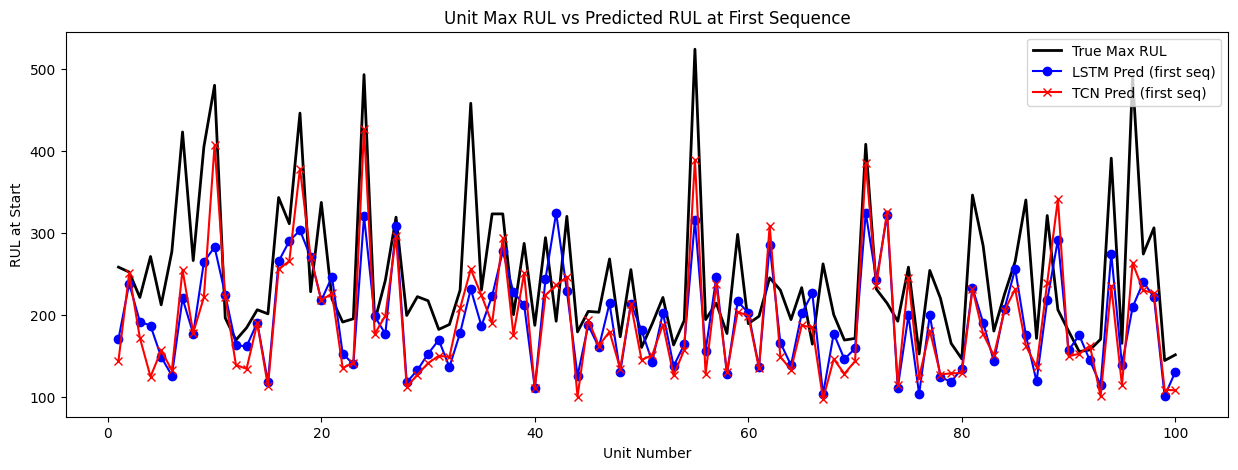

In [47]:
unit_ids = train_df['unit_number'].unique()

true_max_rul = []
lstm_rul_start = []
tcn_rul_start = []

start_idx = 0
for unit in unit_ids:
    unit_len = len(train_df[train_df['unit_number'] == unit])

    max_rul = train_df[train_df['unit_number'] == unit]['RUL'].max()
    true_max_rul.append(max_rul)

    first_seq_idx = start_idx
    lstm_rul_start.append(lstm_pred_all[first_seq_idx][0])
    tcn_rul_start.append(tcn_pred_all[first_seq_idx][0])

    start_idx += unit_len - window_size

df_max = pd.DataFrame({
    'unit_number': unit_ids,
    'True_Max_RUL': true_max_rul,
    'LSTM_FirstSeq_RUL': lstm_rul_start,
    'TCN_FirstSeq_RUL': tcn_rul_start
})

plt.figure(figsize=(15,5))
plt.plot(df_max['unit_number'], df_max['True_Max_RUL'], label='True Max RUL', color='black', linewidth=2)
plt.plot(df_max['unit_number'], df_max['LSTM_FirstSeq_RUL'], label='LSTM Pred (first seq)', color='blue', marker='o')
plt.plot(df_max['unit_number'], df_max['TCN_FirstSeq_RUL'], label='TCN Pred (first seq)', color='red', marker='x')
plt.xlabel('Unit Number')
plt.ylabel('RUL at Start')
plt.title('Unit Max RUL vs Predicted RUL at First Sequence')
plt.legend()
plt.show()

# **Test**

In [48]:
test_df = pd.read_csv('./test_FD003.csv')
rul_df = pd.read_csv('./RUL_FD003.csv')

In [49]:
features = [
    'unit_number', 'time_cycles',
    's_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_10', 's_11',
    's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21'
]
test_df = test_df[features]
test_df.head()

,unit_number,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_10,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,1,1,641.94,1581.93,1396.93,554.56,2387.93,9048.65,1.3,47.09,521.89,2387.94,8133.48,8.3760,391,39.07,23.4468
1,1,2,642.02,1584.86,1398.90,554.10,2387.94,9046.53,1.3,47.08,521.85,2388.01,8137.44,8.4062,391,39.04,23.4807
2,1,3,641.68,1581.78,1391.92,554.41,2387.97,9054.92,1.3,47.15,522.10,2387.94,8138.25,8.3553,391,39.10,23.4244
3,1,4,642.20,1584.53,1395.34,554.58,2387.94,9055.04,1.3,47.26,522.45,2387.96,8137.07,8.3709,392,38.97,23.4782
4,1,5,642.46,1589.03,1395.86,554.16,2388.01,9048.59,1.3,46.94,521.91,2387.97,8134.20,8.4146,391,39.09,23.3950


In [50]:
sensor_names = [c for c in test_df.columns if 's_' in c]
window_size = 30

def create_test_sequences(df, sensor_names, window_size):
    x_test, y_test = [], []
    scaler = MinMaxScaler()
    df_scaled = df.copy()
    df_scaled[sensor_names] = scaler.fit_transform(df[sensor_names])

    unit_max_rul = []

    for unit in df_scaled['unit_number'].unique():
        unit_data = df_scaled[df_scaled['unit_number'] == unit]
        sensors = unit_data[sensor_names].values
        rul = np.arange(len(unit_data)-1, -1, -1)  # Test set RUL: 마지막부터 1씩 감소

        # window_size 마지막 시퀀스만 사용 (혹은 sliding 가능)
        if len(unit_data) >= window_size:
            x_test.append(sensors[-window_size:])
            y_test.append(rul[-1])  # 마지막 시점 RUL
        else:
            # window_size보다 작은 경우 패딩 (앞쪽 반복)
            pad = np.repeat(sensors[0:1], window_size - len(unit_data), axis=0)
            x_test.append(np.vstack([pad, sensors]))
            y_test.append(rul[-1])

        unit_max_rul.append(rul[-1])

    return np.array(x_test), np.array(y_test), unit_max_rul

x_test_seq, y_test_seq, unit_max_rul = create_test_sequences(test_df, sensor_names, window_size)

In [51]:
lstm_pred_test = final_lstm.predict(x_test_seq)

lstm_rmse = np.sqrt(mean_squared_error(y_test_seq, lstm_pred_test))
lstm_mae = mean_absolute_error(y_test_seq, lstm_pred_test)
print(f"RMSE: {lstm_rmse:.3f}, MAE: {lstm_mae:.3f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
RMSE: 51.745, MAE: 39.660


In [52]:
tcn_pred_test = final_tcn.predict(x_test_seq)

tcn_rmse = np.sqrt(mean_squared_error(y_test_seq, tcn_pred_test))
tcn_mae = mean_absolute_error(y_test_seq, tcn_pred_test)
print(f"RMSE: {tcn_rmse:.3f}, MAE: {tcn_mae:.3f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
RMSE: 67.568, MAE: 54.525


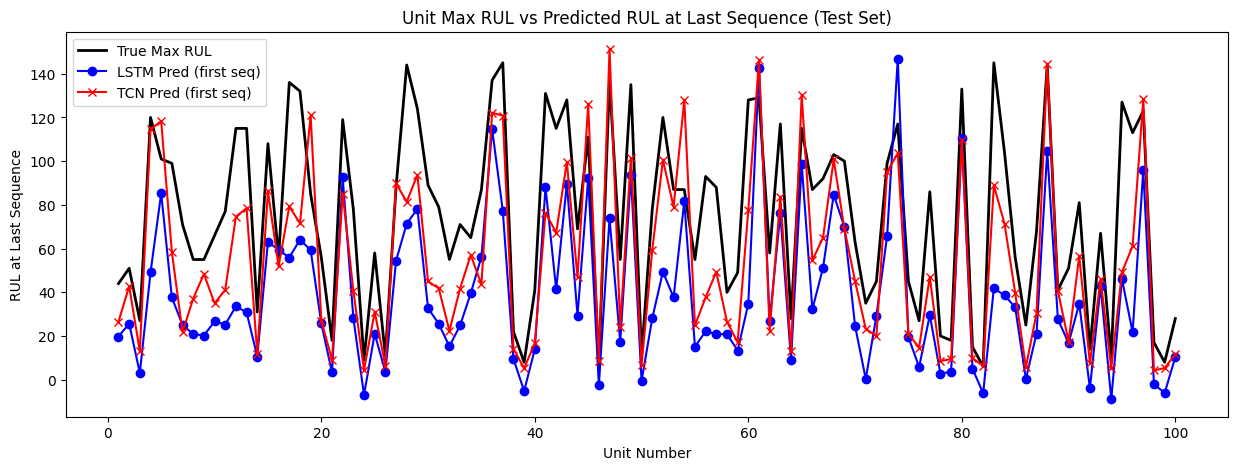

In [53]:
unit_ids = test_df['unit_number'].unique()

true_max_rul = rul_df['RUL'].values.tolist()  # Test set 실제 RUL
lstm_rul_start = []
tcn_rul_start = []

start_idx = 0
for unit in unit_ids:
    # unit별 시퀀스 개수
    unit_len = len(x_test_seq[start_idx:]) if len(x_test_seq[start_idx:]) == 1 else 1  # 마지막 시퀀스만 사용
    lstm_rul_start.append(lstm_pred_test[start_idx][0])
    tcn_rul_start.append(tcn_pred_test[start_idx][0])
    start_idx += unit_len

df_max = pd.DataFrame({
    'unit_number': unit_ids,
    'True_Max_RUL': true_max_rul,
    'LSTM_FirstSeq_RUL': lstm_rul_start,
    'TCN_FirstSeq_RUL': tcn_rul_start
})

plt.figure(figsize=(15,5))
plt.plot(df_max['unit_number'], df_max['True_Max_RUL'], label='True Max RUL', color='black', linewidth=2)
plt.plot(df_max['unit_number'], df_max['LSTM_FirstSeq_RUL'], label='LSTM Pred (first seq)', color='blue', marker='o')
plt.plot(df_max['unit_number'], df_max['TCN_FirstSeq_RUL'], label='TCN Pred (first seq)', color='red', marker='x')
plt.xlabel('Unit Number')
plt.ylabel('RUL at Last Sequence')
plt.title('Unit Max RUL vs Predicted RUL at Last Sequence (Test Set)')
plt.legend()
plt.show()